In [289]:
%load_ext autoreload
%autoreload 2
from naml.modules import torch, plot, nn, optim, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def f(x : torch.Tensor):
    return torch.sin(x) + x**0.8 

noise = 0.5
n_train = 50

x_train, indices = torch.sort(torch.rand(n_train) * 5)
y_train = f(x_train) + torch.normal(0, 0.5, x_train.shape) * noise

x_test = torch.linspace(0, 5, n_train)
y_true = f(x_test)

x_train, y_train

(tensor([0.0517, 0.1887, 0.4303, 0.4485, 0.5958, 0.5958, 0.6512, 0.7926, 0.8175,
         0.8583, 0.8774, 1.0822, 1.1965, 1.3224, 1.3638, 1.3655, 1.4117, 1.6869,
         1.7417, 1.8237, 1.8813, 1.9188, 2.1216, 2.1665, 2.1824, 2.1862, 2.2160,
         2.2302, 2.5296, 2.5775, 2.5852, 2.7412, 2.8061, 2.9593, 3.2587, 3.3183,
         3.3697, 3.4406, 3.4467, 3.5399, 3.5851, 3.6998, 3.8198, 3.8964, 4.0375,
         4.1896, 4.3084, 4.6004, 4.7763, 4.8626]),
 tensor([0.1953, 0.5310, 0.9235, 0.9543, 1.2243, 1.2524, 1.3193, 1.5768, 1.5517,
         1.7169, 1.6285, 1.9343, 2.1231, 2.3044, 2.2615, 2.2994, 2.3029, 2.4676,
         2.4784, 2.5765, 2.5958, 2.5914, 2.6842, 2.7090, 2.6520, 2.6582, 2.6794,
         2.7283, 2.6568, 2.6232, 2.6579, 2.6316, 2.5887, 2.5386, 2.3913, 2.4844,
         2.3648, 2.4627, 2.3951, 2.3307, 2.4253, 2.3008, 2.2867, 2.2915, 2.2648,
         2.2396, 2.2964, 2.3499, 2.5571, 2.5875]))

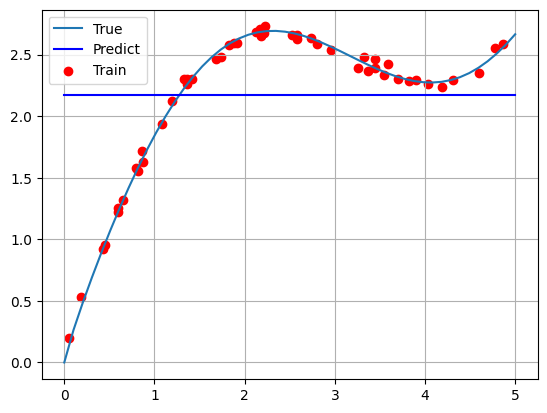

In [291]:
# Average pooling
y_hat = torch.repeat_interleave(y_train.mean(), n_train)
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [292]:
# Weighted with Gaussian kernel
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
x_repeat, x_train

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
         [0.2041, 0.2041, 0.2041,  ..., 0.2041, 0.2041, 0.2041],
         ...,
         [4.7959, 4.7959, 4.7959,  ..., 4.7959, 4.7959, 4.7959],
         [4.8980, 4.8980, 4.8980,  ..., 4.8980, 4.8980, 4.8980],
         [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000]]),
 tensor([0.0517, 0.1887, 0.4303, 0.4485, 0.5958, 0.5958, 0.6512, 0.7926, 0.8175,
         0.8583, 0.8774, 1.0822, 1.1965, 1.3224, 1.3638, 1.3655, 1.4117, 1.6869,
         1.7417, 1.8237, 1.8813, 1.9188, 2.1216, 2.1665, 2.1824, 2.1862, 2.2160,
         2.2302, 2.5296, 2.5775, 2.5852, 2.7412, 2.8061, 2.9593, 3.2587, 3.3183,
         3.3697, 3.4406, 3.4467, 3.5399, 3.5851, 3.6998, 3.8198, 3.8964, 4.0375,
         4.1896, 4.3084, 4.6004, 4.7763, 4.8626]))

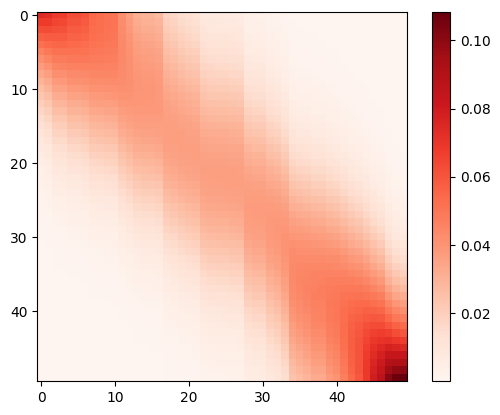

In [293]:
# Closer points have higher weights
w = nn.functional.softmax(-((x_repeat - x_train)**2) / 2, dim=1)
plot.heatmap(w)

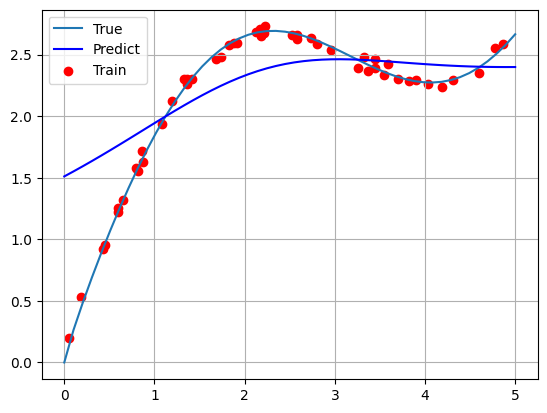

In [294]:
# Nadaraya-Watson kernel regression
y_hat = w @ y_train
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [295]:
class Net(nn.Module):
    M_w : torch.Tensor
    w : nn.Parameter

    def __init__(self):
        super().__init__()
        # Hyperparameter tuning
        # We're only learning the w parameter
        self.w = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, q : torch.Tensor, k : torch.Tensor, v : torch.Tensor):
        M_q = q.repeat_interleave(k.shape[-1]).reshape(-1, k.shape[1])
        self.M_w = M_w = nn.functional.softmax(-(((M_q - k) * self.w) **2) / 2, dim=1)
        return (M_w.unsqueeze(1) @ v.unsqueeze(-1)).reshape(-1) # Flatten
    
x_tiled = x_train.repeat((n_train,1))
y_tiled = y_train.repeat((n_train,1))

print((1-torch.eye(n_train)).bool())
k, v = x_tiled, y_tiled
print(k.shape, v.shape)
# Samples are not allowed to attend to themselves
# XXX: What if we allow this?
k, v = x_tiled[(1-torch.eye(n_train)).bool()], y_tiled[(1-torch.eye(n_train)).bool()]
k, v = k.reshape(-1, n_train-1), v.reshape(-1, n_train-1)
print(k.shape, v.shape)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])
torch.Size([50, 50]) torch.Size([50, 50])
torch.Size([50, 49]) torch.Size([50, 49])


In [296]:
# Train
net = Net()
loss = nn.MSELoss(reduction='none')
list(net.parameters())

[Parameter containing:
 tensor([1.1367], requires_grad=True)]

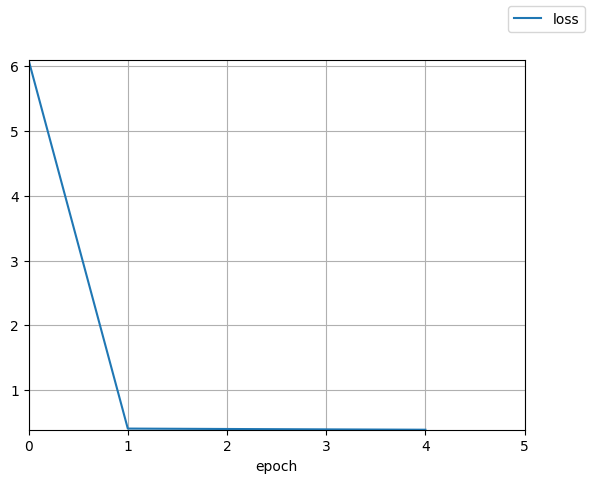

  0%|          | 0/5 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [297]:
opt = optim.SGD(net.parameters(), lr=0.5)
def train():
    for epoch in tqdm(range(5)):
        opt.zero_grad()
        l : torch.Tensor = loss(net(x_train, k, v), y_train)
        l.sum().backward()
        opt.step()        
        yield (l.sum().detach(),)
plot.simple_animated(train())

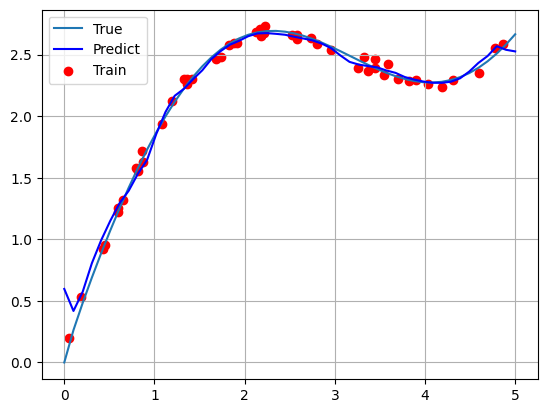

In [298]:
y_hat = net(x_test, k, v).unsqueeze(1).detach()
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

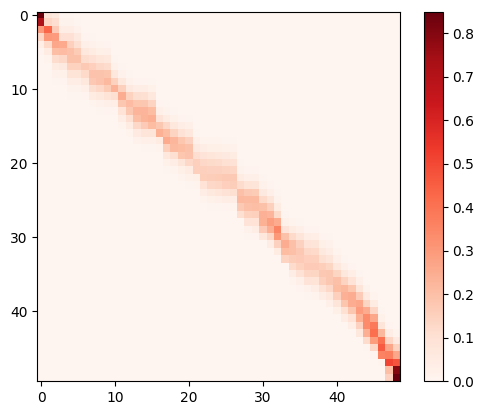

In [299]:
plot.heatmap(net.M_w)